# ***MAKEMORE: NLP MODEL WITH EMBEDDINGS, LR DECAY AND BATCH SPLITS***

### Importing Libs

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

### Reading list of names (all lowered already)

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Building vocab of chars and mapping into integers

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset

In [4]:
block_size = 3
X, Y = [], []
for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

### Train Test Validation splits

In [5]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context.copy())
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
#80% train, 10% validation, 10% test
train = words[:int(.8 * len(words))]
valid = words[int(.8 * len(words)):int(.9 * len(words))]
test = words[int(.9 * len(words)):]

X_train, Y_train = build_dataset(train)
X_valid, Y_valid = build_dataset(valid)
X_test, Y_test = build_dataset(test)

In [6]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [52]:
g = torch.Generator().manual_seed(42)
# Embedding matrix (dimension 10)
emb_dim = 6
C = torch.ones((27, emb_dim))*(1/27.0)
# MLP weights and biases
W1 = torch.randn((emb_dim*block_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
params = [C, W1, b1, W2, b2]

In [53]:
for p in params:
    p.requires_grad = True

# Decay the learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [54]:
lossi = []
lri = []
stepi = []
losses = []
n_steps = 500000
for i in range(n_steps):
    # Minibatch of size 32
    ix = torch.randint(0, X_train.shape[0], (32,))
    # Forward
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, emb_dim*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    # Neg Log lokelihood
    loss = F.cross_entropy(logits, Y[ix])
    #Backward
    for p in params:
        p.grad = None
    loss.backward() 
    # update params
    lr = 0.1 if i < int(.5*n_steps) else 0.01
    # lr = lri[i]
    for p in params:
        p.data -= p.grad * lr
    # lossi.append(loss.item())
    # lri.append(lr)
    stepi.append(i)
    losses.append(loss.item())
print(loss.item())

2.7682735919952393


## Visualize Losses

Text(0, 0.5, 'Loss')

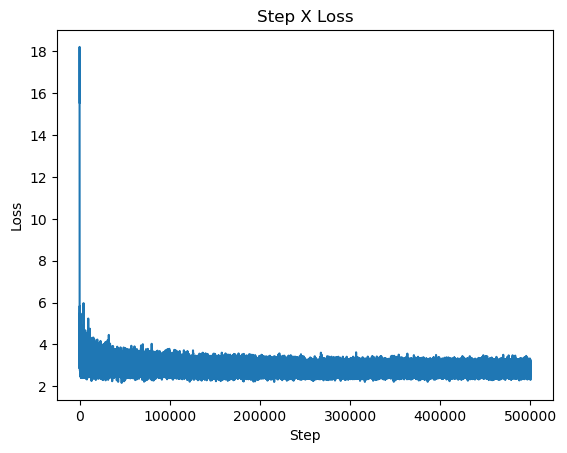

In [46]:
plt.plot(stepi, losses)
plt.title("Step X Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

In [47]:
# plt.subplots(1, 2, figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(lri, lossi)
# plt.title("Learning Rate X Loss")
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.subplot(1, 2, 2)
# plt.plot(lre, lossi)
# plt.title("Exp Learning Rate X Loss")
# plt.xlabel("Exp Learning Rate")
# plt.ylabel("Loss")


## Eval on test and on train set to check over/underfitting

In [55]:
# Evaluate on test set
emb = C[X_test]
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print(f'Test loss: {loss.item()}')

# Evaluate on train set
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(f'Train loss: {loss.item()}')

Test loss: 2.8333327770233154
Train loss: 2.8308684825897217


## Visualize embeddings

In [56]:
C[:, 1]

tensor([ 0.0147,  0.0625, -0.0673,  0.0812,  0.0327, -0.0849,  0.0482,  0.0849,
         0.0116,  0.0620,  0.0408,  0.0190,  0.0013, -0.0472,  0.0286,  0.0121,
         0.1128,  0.0411,  0.0101, -0.0239, -0.0531,  0.0226, -0.1596, -0.0011,
         0.0309, -0.0318,  0.0730], grad_fn=<SelectBackward0>)

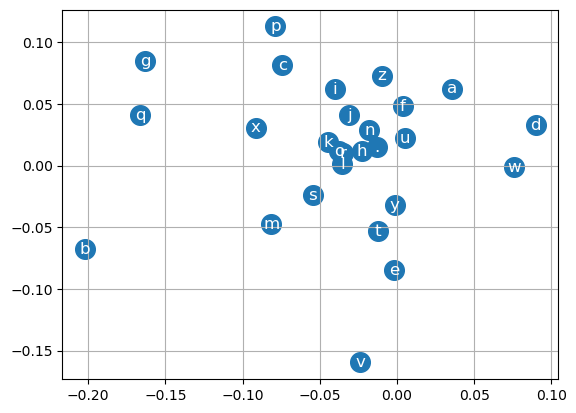

In [57]:
# plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], fontsize=12, ha="center", va="center", color="white")
plt.grid('minor')

## Sampling from the model

In [58]:
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    print(''.join([itos[i] for i in out]))

nlaahbnes.
lryobahnezes.
.
.
vn.
yhoenncnatlrlaaesanmlrqn.
aaaoeuavarm.
.
ecnieo.
mlneuaa.
nrnaee.
zy.
oiss.
.
insaioarnaya.
ehcrunia.
muqaaal.
o.
ofore.
ea.
